# CALCULATING CUSTOMER LIFE TIME VALUE USING PYTHON LIFETIMES PACKAGE


In [34]:
!pip3 install lifetimes

In [54]:
### import libraries
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import seaborn as sns
sns.set_palette("husl")
sns.set(rc={'image.cmap': 'coolwarm'})


In [9]:
### read data
df = pd.read_csv('retail_data.csv', encoding = 'ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [11]:
print(df.shape, '\n')
print(df.info())

(541909, 8) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [23]:
### change date to pandas date time format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df['InvoiceDate'].head()


0    2010-12-01
1    2010-12-01
2    2010-12-01
3    2010-12-01
4    2010-12-01
Name: InvoiceDate, dtype: object

In [18]:
### check for unique cusomter id's 


df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity']>0)]


df['CustomerID'].nunique()

4339

In [37]:
### create sales from quantity and price
df['Sales'] = df['Quantity'] * df['UnitPrice']
df['Sales'].head()

0    15.30
1    20.34
2    22.00
3    20.34
4    20.34
Name: Sales, dtype: float64

In [40]:
### choose only required columns
cols = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[cols]

df.head()

,CustomerID,InvoiceDate,Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [41]:
### using python LIFETIMES module 
from lifetimes import *
from lifetimes.plotting import *
from lifetimes.utils import summary_data_from_transaction_data
#from lifetimes.estimation import *
data = summary_data_from_transaction_data(df,'CustomerID', 'InvoiceDate',
                                         monetary_value_col = 'Sales', observation_period_end ='2011-12-9' )

data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


In [48]:
print(data.describe())


         frequency      recency            T  monetary_value
count  4339.000000  4339.000000  4339.000000     4339.000000
mean      2.864024   130.741415   222.782899      306.944168
std       5.952745   132.210176   117.883623     2612.453380
min       0.000000     0.000000     0.000000        0.000000
25%       0.000000     0.000000   112.000000        0.000000
50%       1.000000    93.000000   248.000000      176.940000
75%       3.000000   252.000000   326.000000      360.161667
max     131.000000   373.000000   373.000000   168469.600000


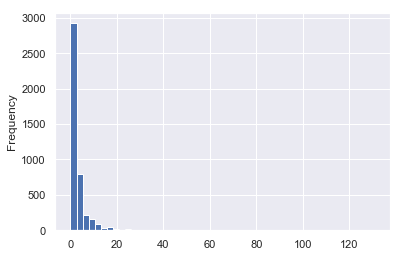

In [55]:
### plit data frequecy

data['frequency'].plot(kind = 'hist', bins = 50)


In [51]:
from lifetimes import BetaGeoFitter
bg = BetaGeoFitter(penalizer_coef=0)
bg.fit(data['frequency'], data['recency'], data['T'])


<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>

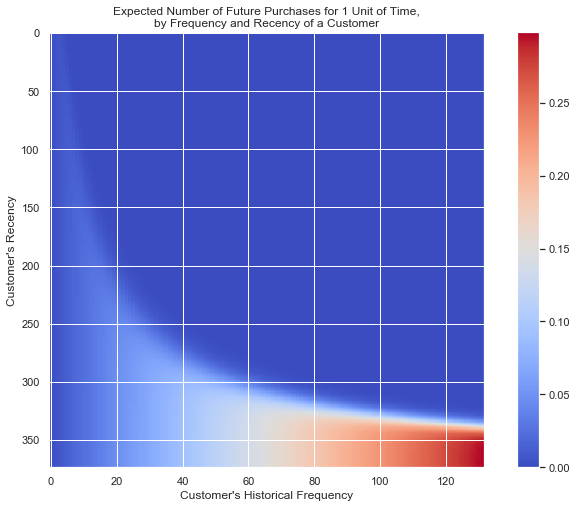

In [56]:
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(12,8))

plot_frequency_recency_matrix(bg)

In [58]:
### predict customer purchases
t = 1
data['predictions'] = bg.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], 
                                                                             data['recency'], data['T'])
data.sort_values(by = 'predictions').tail()

,frequency,recency,T,monetary_value,predictions
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.201005
15311.0,89.0,373.0,373.0,677.729438,0.203269
17841.0,111.0,372.0,373.0,364.452162,0.253053
12748.0,113.0,373.0,373.0,298.360885,0.257581
14911.0,131.0,372.0,373.0,1093.661679,0.298312


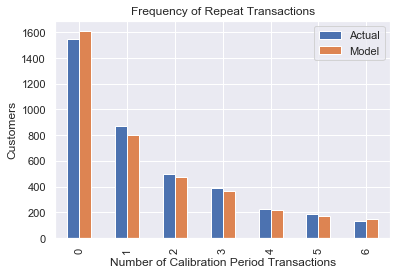

In [59]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bg)

In [63]:
## lets see holdout and calibration data
from lifetimes.utils import calibration_and_holdout_data
summary_hold_cal = calibration_and_holdout_data(df,'CustomerID', 'InvoiceDate',calibration_period_end = '2011-06-08',
                                               observation_period_end = '2011-12-9')
summary_hold_cal.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,141.0,0.0,184
12347.0,2.0,121.0,183.0,4.0,184
12348.0,2.0,110.0,174.0,1.0,184
12350.0,0.0,0.0,126.0,0.0,184
12352.0,3.0,34.0,112.0,3.0,184


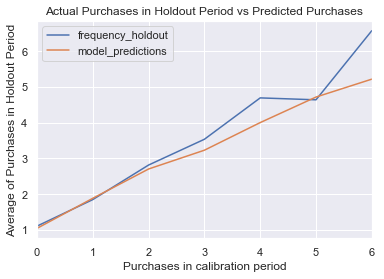

In [65]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bg.fit(summary_hold_cal['frequency_cal'], summary_hold_cal['recency_cal'], summary_hold_cal['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bg, summary_hold_cal)

In [67]:
### predict purchases in 20 periods
t = 20
individual = data.loc[12347]
bg.predict(t,individual['frequency'], individual['recency'], individual['T'])

0.3145548726328218

In [68]:
data.loc[12347]

frequency           6.000000
recency           365.000000
T                 367.000000
monetary_value    599.701667
predictions         0.015656
Name: 12347.0, dtype: float64

In [69]:
customers_return = data[data['frequency']>0]
customers_return.head()


,frequency,recency,T,monetary_value,predictions
CustomerID,,,,,
12347.0,6.0,365.0,367.0,599.701667,0.015656
12348.0,3.0,283.0,358.0,301.480000,0.008956
12352.0,6.0,260.0,296.0,368.256667,0.018697
12356.0,2.0,303.0,325.0,269.905000,0.007172
12358.0,1.0,149.0,150.0,683.200000,0.008340


In [70]:
from lifetimes import GammaGammaFitter
gf = GammaGammaFitter(penalizer_coef=0)
gf.fit(customers_return['frequency'], customers_return['monetary_value'])


<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

In [71]:
gf.conditional_expected_average_profit(data['frequency'], data['monetary_value']).head()

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
dtype: float64

In [73]:
gf.customer_lifetime_value(bg,data['frequency'], data['recency'], data['T'], data['monetary_value'], time = 12,
                          discount_rate=0.01)

CustomerID
12346.0     270.691310
12347.0    3026.930798
12348.0    1005.058350
12349.0    1312.340175
12350.0     281.612756
12352.0    2394.061268
12353.0     393.927481
12354.0     356.382420
12355.0     379.643334
12356.0     776.077893
12357.0    1104.646515
12358.0    1501.080772
12359.0    4876.628018
12360.0    2308.172667
12361.0     300.183495
12362.0    4747.095376
12363.0     661.201037
12364.0    2051.830739
12365.0     296.779857
12367.0    1591.648480
12370.0    1756.212719
12371.0    1904.212391
12372.0    1132.731074
12373.0     280.857315
12374.0    1206.481297
12375.0    1213.353921
12377.0     727.557048
12378.0     548.789822
12379.0    1030.299991
12380.0    3201.335273
              ...     
18242.0    2560.929888
18245.0    1999.368847
18246.0     783.162354
18248.0     870.638959
18249.0    1328.998571
18250.0     281.612756
18251.0     703.711512
18252.0    1101.087684
18255.0     694.377200
18257.0    2216.126325
18259.0    1675.143702
18260.0    2171.911445
